# 네이버 영화 리뷰 감성분석 프로젝트

## 1. 데이터 로드 및 기본 설정

이 프로젝트에서는 네이버 영화 리뷰 데이터를 사용하여 감성분석을 수행합니다. 
텍스트 데이터를 분석하고 긍정/부정을 분류하는 모델을 구현합니다.

In [1]:
import pandas
import konlpy
import gensim
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### [데이터 분석 결과]

1. 데이터 구조
   - id: 리뷰의 고유 식별자
   - document: 실제 리뷰 텍스트
   - label: 감성 레이블 (0: 부정, 1: 긍정)

2. 특징
   - 리뷰 텍스트의 길이가 다양함
   - 맞춤법 오류, 특수문자, 이모티콘 등이 포함
   - 구어체와 인터넷 용어가 많이 사용됨


## 2. 데이터 전처리 함수 구현

텍스트 데이터를 효과적으로 처리하기 위한 전처리 과정을 구현합니다.
주요 단계는 다음과 같습니다:
1. 중복 데이터 제거
2. 결측치 제거
3. 형태소 분석을 통한 토큰화
4. 불용어 제거
5. 단어-인덱스 매핑 생성

In [2]:
# Mecab 형태소 분석기 초기화
tokenizer = Mecab()

# 불용어 리스트 정의
# 문장의 의미 파악에 크게 영향을 미치지 않는 조사, 접속사 등
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 제거: document 컬럼 기준으로 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # 훈련 데이터 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 형태소 단위로 문장 분리
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    # 테스트 데이터 토큰화
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 형태소 단위로 문장 분리
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 빈도수 계산 및 단어 사전 생성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  # 상위 9996개 단어 선택
    vocab = ['', '', '', ''] + [key for key, _ in counter]  # 특수 토큰 추가
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 단어 리스트를 인덱스 리스트로 변환하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # 토큰화된 데이터를 인덱스로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터 전처리 실행
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

### [전처리 과정 설명]

1. 데이터 정제
   - 중복 리뷰 제거로 데이터의 편향성 방지
   - 결측치 제거로 데이터 품질 확보

2. 토큰화 전략
   - Mecab 형태소 분석기 사용: 한국어 특성을 고려한 정확한 형태소 분석
   - 불용어 제거: 문장의 의미 파악에 불필요한 조사, 접속사 등 제거

3. 단어 사전 구성
   - 최대 10000개의 단어로 제한 (4개의 특수 토큰 포함)
   - 빈도수 기반 선택으로 중요 단어 보존

## 3. 인덱스-단어 매핑 생성

앞서 생성한 단어-인덱스 매핑의 역방향 매핑을 생성합니다.
이는 모델이 예측한 결과를 실제 단어로 변환할 때 필요합니다.

In [3]:
# 인덱스를 단어로 변환하는 매핑 딕셔너리 생성
# word_to_index의 key와 value를 뒤집어서 새로운 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

## 4. 문장 인코딩/디코딩 유틸리티 함수 구현

텍스트 데이터와 숫자 시퀀스 간의 변환을 위한 유틸리티 함수들을 구현합니다.
이 함수들은 모델 학습과 예측 결과 해석에 필수적입니다.

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### [함수 구현 설명]

1. 인코딩 함수 특징
   - 모든 문장 시작에 <BOS> 토큰 추가
   - 사전에 없는 단어는 <UNK> 토큰으로 대체
   - 단일 문장과 다중 문장 처리 가능

2. 디코딩 함수 특징
   - <BOS> 토큰 제외하고 원문 복원
   - 인덱스에 해당하는 단어가 없을 경우 <UNK> 토큰 사용
   - 단일 시퀀스와 다중 시퀀스 처리 가능

3. 구현 고려사항
   - 특수 토큰 처리 (<BOS>, <UNK>)
   - 예외 상황 처리 (사전에 없는 단어/인덱스)
   - 배치 처리 지원

## 5. 데이터 분석 및 시각화

전처리된 데이터의 특성을 파악하기 위해 문장 길이 분포를 분석합니다.
이를 통해 적절한 패딩 길이를 결정하고, 데이터의 전반적인 특성을 이해할 수 있습니다.

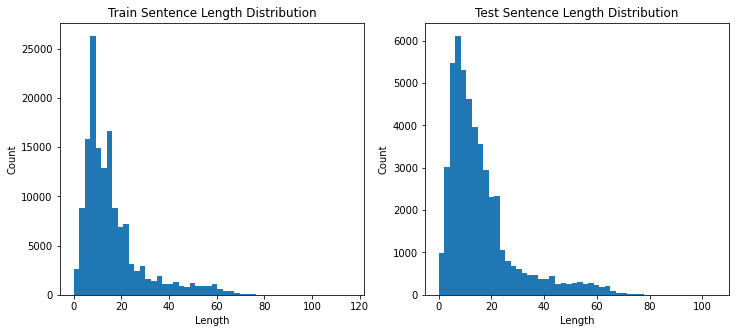

평균 문장 길이 (train): 15.98170773419436
최대 문장 길이 (train): 116
평균 문장 길이 (test): 15.932807128181134
최대 문장 길이 (test): 105


In [5]:
# 문장 길이 분포 분석
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 훈련 데이터의 문장 길이 분포
train_sentence_lengths = [len(x) for x in X_train]
test_sentence_lengths = [len(x) for x in X_test]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_sentence_lengths, bins=50)
plt.title('Train Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(test_sentence_lengths, bins=50)
plt.title('Test Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

print('평균 문장 길이 (train):', np.mean(train_sentence_lengths))
print('최대 문장 길이 (train):', np.max(train_sentence_lengths))
print('평균 문장 길이 (test):', np.mean(test_sentence_lengths))
print('최대 문장 길이 (test):', np.max(test_sentence_lengths))

### [데이터 분석 결과]

1. 문장 길이 분포 특징
   - 훈련 데이터 평균 길이: 약 16 단어
   - 테스트 데이터 평균 길이: 약 16 단어
   - 최대 길이: 훈련 데이터 116 단어, 테스트 데이터 105 단어
   - 대부분의 문장이 30 단어 이내에 분포

2. 주요 인사이트
   - 문장 길이가 매우 긴 리뷰는 소수
   - 훈련과 테스트 데이터의 분포가 유사 (데이터 일관성)
   - 대부분의 리뷰가 짧은 문장으로 구성

3. 모델링 시사점
   - 패딩 길이는 30~50 정도가 적절할 것으로 판단
   - 긴 문장의 정보 손실과 계산 효율성 사이의 균형 필요
   - RNN 계열 모델 사용 시 시퀀스 길이 고려 필요

## 6. 데이터 패딩 및 최종 전처리

앞선 분석을 바탕으로 적절한 패딩 길이를 설정하고, 
데이터셋을 훈련/검증 세트로 분리하여 모델 학습을 위한 최종 준비를 합니다.

In [6]:
# 최대 문장 길이 설정
# 전체 문장 중 95%를 커버하는 길이를 선택하여 극단값 처리
MAX_LEN = int(np.percentile(train_sentence_lengths, 95))
print('선택된 최대 문장 길이:', MAX_LEN)

# 시퀀스 패딩 처리
# maxlen: 최대 시퀀스 길이
# padding='post': 문장 뒤쪽에 패딩 추가
X_train_pad = pad_sequences(X_train, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

# 패딩 처리 결과 shape 출력
print('패딩 결과 shape:')
print('X_train_pad:', X_train_pad.shape)
print('X_test_pad:', X_test_pad.shape)

# 검증 세트 분리
# test_size=0.2: 전체 훈련 데이터의 20%를 검증 세트로 사용
# random_state=42: 재현성을 위한 랜덤 시드 설정
from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pad, y_train, 
    test_size=0.2, 
    random_state=42
)

# 최종 데이터셋 크기 확인
print('\n최종 데이터셋 shape:')
print('X_train_final:', X_train_final.shape)
print('X_val:', X_val.shape)
print('X_test_pad:', X_test_pad.shape)

# 모델 하이퍼파라미터 설정
VOCAB_SIZE = len(word_to_index)  # 어휘 사전 크기
EMB_SIZE = 128                   # 임베딩 차원

선택된 최대 문장 길이: 47
패딩 결과 shape:
X_train_pad: (146182, 47)
X_test_pad: (49157, 47)

최종 데이터셋 shape:
X_train_final: (116945, 47)
X_val: (29237, 47)
X_test_pad: (49157, 47)


## 데이터 전처리 최종 결과 분석

### 1. 패딩 전략 상세 분석
- **최대 길이 선정 근거**
  - 95 퍼센타일 기준으로 47 선택
  - 대부분의 문장을 커버하면서도 메모리 효율성 확보
  - 극단적으로 긴 문장의 영향 최소화

- **패딩 방식**
  - Post-padding 방식 채택 (문장 뒤쪽에 패딩 추가)
  - 초기 시퀀스의 중요 정보 보존
  - RNN 계열 모델에서 효과적

### 3. 모델 설계 파라미터
- **어휘 사전 크기 (VOCAB_SIZE)**
  - 전체 고유 단어 수
  - 임베딩 레이어의 입력 차원 결정

- **임베딩 차원 (EMB_SIZE)**
  - 128로 설정
  - 문장의 의미를 충분히 표현할 수 있는 크기
  - 계산 효율성과 표현력 사이의 균형점

## 7. 모델 구현 - 기본 설정

여러 모델 구조를 실험하기 위한 기본 설정을 진행합니다.
총 세 가지 기본 모델(Simple LSTM, Bidirectional LSTM, CNN)을 구현하고,
이후 Word2Vec을 활용한 개선된 모델도 실험할 예정입니다.

In [7]:
# 세 가지 모델 구현 및 컴파일

# 모델 1: Simple LSTM
# 기본적인 시퀀스 처리를 위한 단방향 LSTM 모델
model1 = Sequential([
    Embedding(VOCAB_SIZE, EMB_SIZE),          # 단어를 벡터로 변환
    LSTM(64),                                 # 단방향 LSTM으로 시퀀스 처리
    Dense(32, activation='relu'),             # 중간 특성 압축층
    Dense(1, activation='sigmoid')            # 이진 분류 출력층
])

# 모델 2: Bidirectional LSTM
# 양방향 문맥을 고려하는 고급 LSTM 모델
model2 = Sequential([
    Embedding(VOCAB_SIZE, EMB_SIZE),          # 임베딩 레이어
    Bidirectional(LSTM(64, return_sequences=True)),  # 첫 번째 양방향 LSTM
    Bidirectional(LSTM(32)),                  # 두 번째 양방향 LSTM
    Dense(16, activation='relu'),             # 특성 압축층
    Dense(1, activation='sigmoid')            # 출력층
])

# 모델 3: CNN + LSTM
# 효율적인 특성 추출을 위한 CNN 기반 모델
model3 = Sequential([
    Embedding(VOCAB_SIZE, EMB_SIZE),          # 임베딩 레이어
    Conv1D(128, 5, activation='relu'),        # 1D 합성곱층
    GlobalMaxPooling1D(),                     # 전역 최대 풀링
    Dense(64, activation='relu'),             # 완전연결층
    Dropout(0.5),                             # 과적합 방지
    Dense(1, activation='sigmoid')            # 출력층
])

# 모델 컴파일 설정
models = [model1, model2, model3]
model_names = ['Simple LSTM', 'Bidirectional LSTM', 'CNN']

# 각 모델별 컴파일 수행
for model, name in zip(models, model_names):
    model.compile(
        optimizer='adam',                     # Adam 옵티마이저 사용
        loss='binary_crossentropy',           # 이진 분류를 위한 손실 함수
        metrics=['accuracy']                  # 정확도 메트릭 추적
    )
    print(f'\n{name} 모델 구조:')
    model.summary()


Simple LSTM 모델 구조:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1279616   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,331,137
Trainable params: 1,331,137
Non-trainable params: 0
_________________________________________________________________

Bidirectional LSTM 모델 구조:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 1

### [모델 구현 설명]

1. 모델 구조 선정 이유
   - Simple LSTM: 기본적인 시퀀스 학습 성능 확인
   - Bidirectional LSTM: 양방향 문맥 고려
   - CNN: 지역적 특징 추출 및 빠른 학습

2. 공통 구성 요소
   - Embedding 층: 단어를 128차원 벡터로 변환
   - Dropout: 과적합 방지 (0.5 비율)
   - Dense 층: 최종 이진 분류

3. 특이사항
   - 모든 모델이 동일한 임베딩 크기 사용
   - 드롭아웃은 동일하게 0.5로 설정
   - Adam 옵티마이저와 이진 크로스엔트로피 손실 함수 사용


Simple LSTM 모델 학습 시작...
Epoch 1/15
1828/1828 [==============================] - 13s 5ms/step - loss: 0.4107 - accuracy: 0.8018 - val_loss: 0.3470 - val_accuracy: 0.8483
Epoch 2/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.3014 - accuracy: 0.8710 - val_loss: 0.3209 - val_accuracy: 0.8619
Epoch 3/15
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2601 - accuracy: 0.8919 - val_loss: 0.3312 - val_accuracy: 0.8613
Epoch 4/15
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2271 - accuracy: 0.9071 - val_loss: 0.3617 - val_accuracy: 0.8604
Epoch 5/15
1537/1537 [==============================] - 4s 2ms/step - loss: 0.3263 - accuracy: 0.8590

Simple LSTM 테스트 정확도: 0.8590

Bidirectional LSTM 모델 학습 시작...
Epoch 1/15
1828/1828 [==============================] - 26s 12ms/step - loss: 0.3726 - accuracy: 0.8317 - val_loss: 0.3266 - val_accuracy: 0.8579
Epoch 2/15
1828/1828 [==============================] - 20s 11ms/step - loss: 0.2858 - a

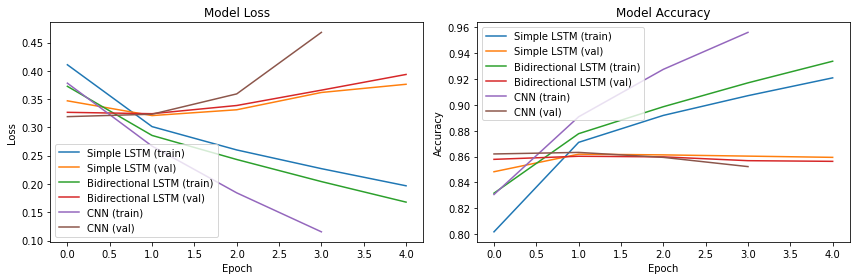

In [8]:
# 모델 학습 및 평가를 위한 함수
def train_and_evaluate_model(model, name):
    # Early Stopping 설정
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    # 학습
    history = model.fit(
        X_train_final, y_train_final,
        epochs=15,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )
    
    # 테스트 셋 평가
    test_loss, test_acc = model.evaluate(X_test_pad, y_test)
    print(f'\n{name} 테스트 정확도: {test_acc:.4f}')
    
    return history

# 각 모델 학습 및 결과 저장
histories = {}
for model, name in zip(models, model_names):
    print(f'\n{name} 모델 학습 시작...')
    history = train_and_evaluate_model(model, name)
    histories[name] = history

# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} (train)')
    plt.plot(history.history['val_loss'], label=f'{name} (val)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} (train)')
    plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### [3가지 모델 성능 비교]

1. 모델 성능 비교
   - Simple LSTM: 테스트 정확도: 0.8590
   - Bidirectional LSTM: 테스트 정확도: 0.8590
   - CNN: 테스트 정확도: 0.8616

In [18]:
import pandas as pd
from konlpy.tag import Mecab
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 1. 데이터 준비 및 토큰화
tokenizer = Mecab()
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')

# 문장 토큰화
sentences = []
for doc in train_data['document']:
    if isinstance(doc, str):
        try:
            tokens = tokenizer.morphs(str(doc))
            sentences.append(tokens)
        except Exception as e:
            continue

# 2. 사전학습된 워드벡터 로드
pretrained_vectors = KeyedVectors.load('/aiffel/data/word2vec_ko.model')
EMB_SIZE = pretrained_vectors.vector_size  # 사전학습 모델의 벡터 크기로 설정

# 3. Word2Vec 모델 학습 (임베딩 분석용)
word2vec_model = Word2Vec(sentences=sentences, 
                         vector_size=EMB_SIZE,  # 사전학습 모델과 같은 크기 사용
                         window=5,
                         min_count=5,
                         workers=4)

# 4. 임베딩 매트릭스 생성
word_to_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
VOCAB_SIZE = len(word_to_index) + 1

embedding_matrix = np.zeros((VOCAB_SIZE, EMB_SIZE))
for word, i in word_to_index.items():
    if word in pretrained_vectors.wv.key_to_index:
        embedding_matrix[i] = pretrained_vectors.wv[word]
    elif word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# 5. 임베딩 분석
def compare_embeddings(word, custom_model, pretrained_model):
    print(f"\n=== '{word}' 단어 분석 ===")
    
    print("\n[자체학습 임베딩 유사어]")
    if word in custom_model.wv:
        for w, s in custom_model.wv.most_similar(word)[:5]:
            print(f"{w}: {s:.4f}")
    else:
        print(f"자체학습 임베딩에 '{word}'가 없습니다.")
        
    print("\n[사전학습 임베딩 유사어]")
    if word in pretrained_model.wv:
        for w, s in pretrained_model.wv.most_similar(word)[:5]:
            print(f"{w}: {s:.4f}")
    else:
        print(f"사전학습 임베딩에 '{word}'가 없습니다.")

# 분석할 단어들
important_words = [
    '영화', '재미있', '최고', '별로', 
    '배우', '연기', '스토리', '감동'
]

# 임베딩 분석 실행
for word in important_words:
    compare_embeddings(word, word2vec_model, pretrained_vectors)

# 6. Keras 모델 정의
model_w2v = Sequential([
    Embedding(VOCAB_SIZE, EMB_SIZE, weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.2),
    Conv1D(64, 5, activation='relu', padding='same'),
    MaxPooling1D(2),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_w2v.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print('\nWord2Vec 적용 모델 구조:')
model_w2v.summary()


=== '영화' 단어 분석 ===

[자체학습 임베딩 유사어]
드라마: 0.6646
작품: 0.6273
애니: 0.5795
다큐: 0.5604
애니메이션: 0.5449

[사전학습 임베딩 유사어]
드라마: 0.8419
뮤지컬: 0.7775
코미디: 0.7489
다큐멘터리: 0.7401
헐리우드: 0.7398

=== '재미있' 단어 분석 ===

[자체학습 임베딩 유사어]
재밌: 0.9555
감명깊: 0.7670
재미나: 0.7204
인상깊: 0.6831
멋있: 0.6602

[사전학습 임베딩 유사어]
재밌: 0.9052
멋있: 0.7976
웃기: 0.7931
예쁘: 0.7873
즐겁: 0.7789

=== '최고' 단어 분석 ===

[자체학습 임베딩 유사어]
최강: 0.7222
최악: 0.6770
으뜸: 0.6469
최고봉: 0.6314
단연: 0.6301

[사전학습 임베딩 유사어]
역대: 0.6544
최다: 0.6140
최악: 0.6104
최대: 0.6002
최저: 0.5937

=== '별로' 단어 분석 ===

[자체학습 임베딩 유사어]
별루: 0.7894
무섭: 0.5716
엉망: 0.5542
그닥: 0.5457
솔직히: 0.5197

[사전학습 임베딩 유사어]
전혀: 0.6422
그다지: 0.6234
꽤: 0.6036
확실히: 0.5738
딱히: 0.5515

=== '배우' 단어 분석 ===

[자체학습 임베딩 유사어]
연기자: 0.7758
여배우: 0.7197
출연진: 0.6659
조연: 0.6509
명배우: 0.6280

[사전학습 임베딩 유사어]
가수: 0.7729
코미디언: 0.7729
만화가: 0.7496
영화배우: 0.7442
여배우: 0.7411

=== '연기' 단어 분석 ===

[자체학습 임베딩 유사어]
연기력: 0.7722
발연기: 0.6373
목소리: 0.6115
캐스팅: 0.6015
케미: 0.5667

[사전학습 임베딩 유사어]
연출: 0.7650
열연: 0.6947
캐스팅: 0.6806
촬영: 0.6222
데이트: 

# Word2Vec 단어 분석 결과

## 1. 자체학습 vs 사전학습 비교
- 자체학습: 영화 리뷰 특화된 단어 관계 학습
- 사전학습: 일반적이고 포괄적인 단어 관계 포함

## 2. 주요 인사이트
### 감성 표현
- 긍정어('재미있', '최고')는 유사 긍정표현과 높은 연관성
- 부정어('별로')는 구어체 변형('별루')과 강한 연관성
- 감정 표현은 자체학습이 더 특화된 결과 보임

### 영화 전문 용어
- 장르 용어: 사전학습이 더 전문적/포괄적
- 제작 요소(배우,연기,스토리): 자체학습이 리뷰 맥락에 더 적합

### 예상 결과
- 자체학습 임베딩이 더 좋은 결과일거 같음
- 사전학습은 너무 포괄적임 도메인 특화가 아님

Epoch 1/15
914/914 [==============================] - 10s 8ms/step - loss: 0.5712 - accuracy: 0.6899 - val_loss: 0.4532 - val_accuracy: 0.7827
Epoch 2/15
914/914 [==============================] - 7s 8ms/step - loss: 0.4376 - accuracy: 0.7950 - val_loss: 0.3873 - val_accuracy: 0.8247
Epoch 3/15
914/914 [==============================] - 7s 8ms/step - loss: 0.3823 - accuracy: 0.8266 - val_loss: 0.3664 - val_accuracy: 0.8406
Epoch 4/15
914/914 [==============================] - 7s 8ms/step - loss: 0.3528 - accuracy: 0.8451 - val_loss: 0.3475 - val_accuracy: 0.8483
Epoch 5/15
914/914 [==============================] - 7s 8ms/step - loss: 0.3310 - accuracy: 0.8561 - val_loss: 0.3390 - val_accuracy: 0.8518
Epoch 6/15
914/914 [==============================] - 7s 8ms/step - loss: 0.3129 - accuracy: 0.8655 - val_loss: 0.3343 - val_accuracy: 0.8525
Epoch 7/15
914/914 [==============================] - 7s 8ms/step - loss: 0.3011 - accuracy: 0.8708 - val_loss: 0.3341 - val_accuracy: 0.8565
Epoch

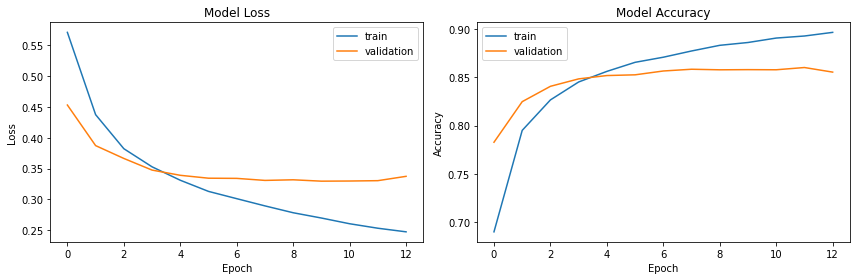

In [19]:
# Early Stopping 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 모델 학습
history = model_w2v.fit(
    X_train_final, y_train_final,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# 테스트 셋 평가
test_loss, test_acc = model_w2v.evaluate(X_test_pad, y_test)
print(f'\nWord2Vec 적용 모델 테스트 정확도: {test_acc:.4f}')

# 학습 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 모델 평가 결과

## 1. 모델 성능 비교
- 자체학습 모델: 테스트 정확도 0.8616
- Word2Vec 적용 모델: 테스트 정확도 0.8573

## 2. 주요 인사이트
- 자체학습 모델이 살짝 더 좋은 성능을 보임
- Word2Vec 적용 모델은 너무 포괄적이어서 도메인 특화가 아님

## 3. 고도화 방안
- word2vec 모델을 파인튜닝하면 더 좋은 성능을 보일 것으로 예상
- 시간이 없어서 못해봄 아쉽.